In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as _plt
import seaborn as sns
import scipy.stats as st
import folium 
import requests # library to handle requests
import json # library to handle JSON f2iles

ams_lat = 52.3667
ams_long = 4.8945

#### Load Data

In [67]:
# Load Amsterdam Airbnb data
df_listings = pd.read_csv('data/listings.csv')

#Remove outliers
df_listings['reviews_per_month'].fillna(0, inplace=True)
df_listings = df_listings.query('price>0') #Remove $0 listings
df_listings = df_listings.query('minimum_nights<121') #Remove listings which require >6month stay
df_listings = df_listings.query('room_type != "Hotel room"') #Remove Hotel room listings
df_listings.describe(include="all")

#Get number of listings in each neighbourhood
neighbourhood_count = df_listings.groupby(by="neighbourhood").agg("count")[['id']].rename(columns={'id':'count'}).reset_index()
#df_listings = df_listings[df_listings.columns[5:]]
df_listings.describe(include="all")

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,1.934800e+04,19315,1.934800e+04,19345,0.0,19348,19348.000000,19348.000000,19348,19348.000000,19348.000000,19348.000000,17140,19348.000000,19348.000000,19348.000000
unique,NaN,18918,NaN,5826,NaN,22,NaN,NaN,3,NaN,NaN,NaN,1551,NaN,NaN,NaN
top,NaN,Amsterdam,NaN,Martijn,NaN,De Baarsjes - Oud-West,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2020-03-08,NaN,NaN,NaN
freq,NaN,36,NaN,115,NaN,3288,NaN,NaN,15293,NaN,NaN,NaN,392,NaN,NaN,NaN
mean,1.961680e+07,NaN,6.105141e+07,NaN,NaN,NaN,52.365323,4.889590,NaN,160.678055,3.150403,25.183016,NaN,0.780625,1.808197,46.328716
std,1.198703e+07,NaN,7.750677e+07,NaN,NaN,NaN,0.016461,0.036170,NaN,170.165752,4.451518,53.386542,NaN,1.298008,3.672185,89.487452
min,2.818000e+03,NaN,3.159000e+03,NaN,NaN,NaN,52.289270,4.752370,NaN,5.000000,1.000000,0.000000,NaN,0.000000,1.000000,0.000000
25%,9.772250e+06,NaN,8.958683e+06,NaN,NaN,NaN,52.355078,4.863620,NaN,99.000000,2.000000,3.000000,NaN,0.120000,1.000000,0.000000
50%,1.861014e+07,NaN,2.640307e+07,NaN,NaN,NaN,52.364670,4.887130,NaN,130.000000,2.000000,9.000000,NaN,0.380000,1.000000,0.000000
75%,2.869737e+07,NaN,8.046247e+07,NaN,NaN,NaN,52.375240,4.909383,NaN,185.000000,3.000000,24.000000,NaN,0.830000,1.000000,44.000000


### Type of listings

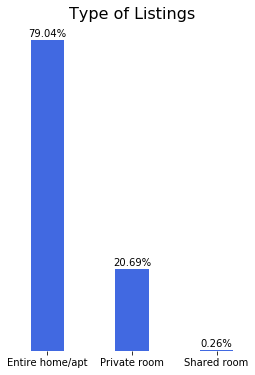

In [68]:
df_listings_type = df_listings.groupby(by='room_type').count()['id'].reset_index()
df_listings_type['id'] = df_listings_type['id'].apply(lambda x: x*100/df_listings.shape[0])
df_listings_type = df_listings_type.sort_values('id',ascending=False)

fig, ax = _plt.subplots(figsize=(4, 6))
_plt.bar(df_listings_type['room_type'],df_listings_type['id'], width=.4, color=('royalblue'))
ax.set_title('Type of Listings', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().set_ticks([])
ax.get_xaxis()

for rect in ax.patches:
    ax.text(rect.get_x()+rect.get_width()/2, rect.get_height()+3, '{}%'.format(rect.get_height().round(2)), ha='center', va='top')
_plt.savefig('resources/listing_type.png')
_plt.show()

## Price

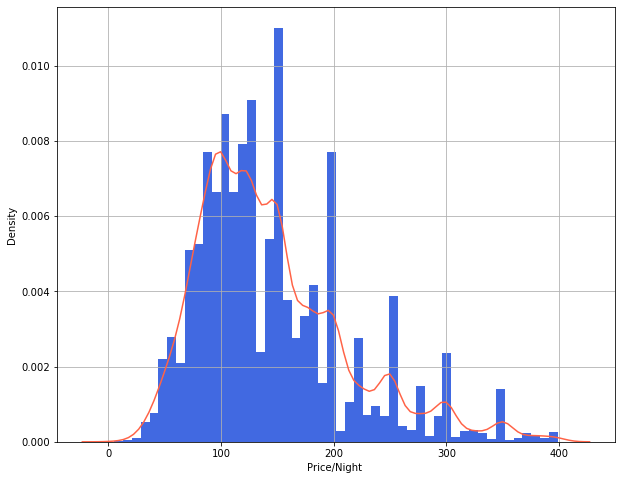

In [69]:
bins = 50
fig, ax = _plt.subplots(figsize=(10, 8))
_plt.grid(b=None)
df_listings_lt_400 = df_listings.query('price<400')
ax = sns.distplot(df_listings_lt_400['price'], bins=bins, kde=True, color='tomato', hist_kws={"linewidth": 10,'alpha':1, 'color':'royalblue'})
ax.set(xlabel='Price/Night ', ylabel='Density')
_plt.savefig('resources/price_dist.png')
_plt.show()

### Plot of listing prices by Room Type below 400 USD

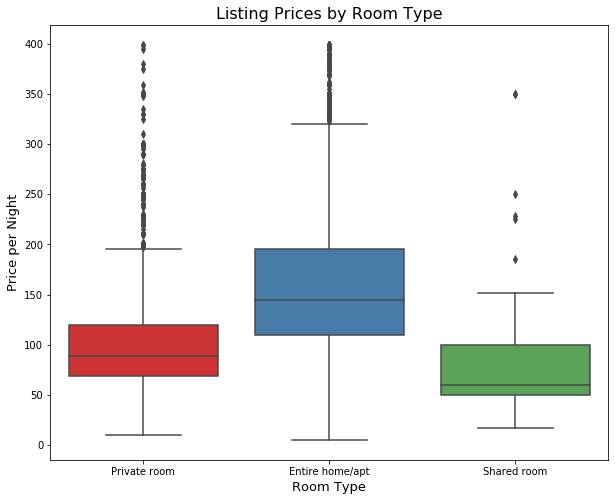

In [70]:
fig, ax = _plt.subplots(figsize=(10, 8))
ax = sns.boxplot(x='room_type', y='price', data=df_listings_lt_400, palette="Set1")
ax.set_xlabel('Room Type',fontsize=13)
ax.set_ylabel('Price per Night',fontsize=13)
ax.set_title('Listing Prices by Room Type', fontsize=16)
_plt.savefig('resources/room_type_price_boxplot.png')
_plt.show()

In [71]:
with open('data/neighbourhoods.json','r') as json_data:
    ams_geojson = json.load(json_data)

In [72]:
neighbourhood_price = df_listings.groupby(by="neighbourhood").agg("mean")[['price']].reset_index()
map_ams = folium.Map(location=[ams_lat, ams_long], zoom_start=12)
map_ams.choropleth(
    geo_data=ams_geojson,
    data=neighbourhood_price,
    columns=['neighbourhood', 'price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrBr', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name="Average Price of Listings in each Neighborhood"
) 

top_100 = df_listings_lt_400[['room_type','latitude','longitude','price','neighbourhood']].sort_values(by='price', ascending=False).head(100)
for lat, lng, room_type, price, neighborhood in zip(top_100['latitude'], top_100['longitude'], top_100['room_type'], top_100['price'], top_100['neighbourhood'] ):
    label = folium.Popup('{} in {} : USD{}'.format(room_type, neighborhood,price), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='indigo',
        fill=True,
        fill_color='indigo',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)

bottom_100 = df_listings_lt_400[['room_type','latitude','longitude','reviews_per_month','price','neighbourhood']].sort_values(by='price', ascending=False).tail(100)
for lat, lng, room_type, price, neighborhood in zip(bottom_100['latitude'], bottom_100['longitude'], bottom_100['room_type'], bottom_100['price'], bottom_100['neighbourhood'] ):
    label = folium.Popup('{} in {} : USD{}'.format(room_type, neighborhood,price), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)
    
legend_html = '<div style="position: fixed; background: rgba(255, 255, 255, 0.8); \
                top: 20px; left: 50px; width: 350px; height: 40px; \
                border:2px solid grey; z-index:9999; font-size:16px;"> \
                        &nbsp; Most Expensive &nbsp; <i class="fa fa-circle fa-2x" style="color:indigo"></i> \
                        &nbsp; Least Expensive &nbsp; <i class="fa fa-circle fa-2x" style="color:green"></i> \
              </div>'
map_ams.get_root().html.add_child(folium.Element(legend_html))

# save map
map_ams.save(outfile='resources/map_amsterdam.html')   

# display map
map_ams

In [73]:
df_listings_lt_400[['neighbourhood','price']].groupby(by='neighbourhood').mean().sort_values('price', ascending=False).reset_index()\
        .rename(columns={'price':'Average Price','neighbourhood':'Neighborhood'}).head(3)

,Neighborhood,Average Price
0,Centrum-Oost,171.053273
1,Centrum-West,167.996933
2,Zuid,156.900548


In [74]:
df_listings_lt_400[['neighbourhood','price']].groupby(by='neighbourhood').mean().sort_values('price', ascending=True).reset_index()\
        .rename(columns={'price':'Average Price','neighbourhood':'Neighborhood'}).head(3)

,Neighborhood,Average Price
0,Bijlmer-Centrum,90.973913
1,Bijlmer-Oost,92.675926
2,Gaasperdam - Driemond,94.358333


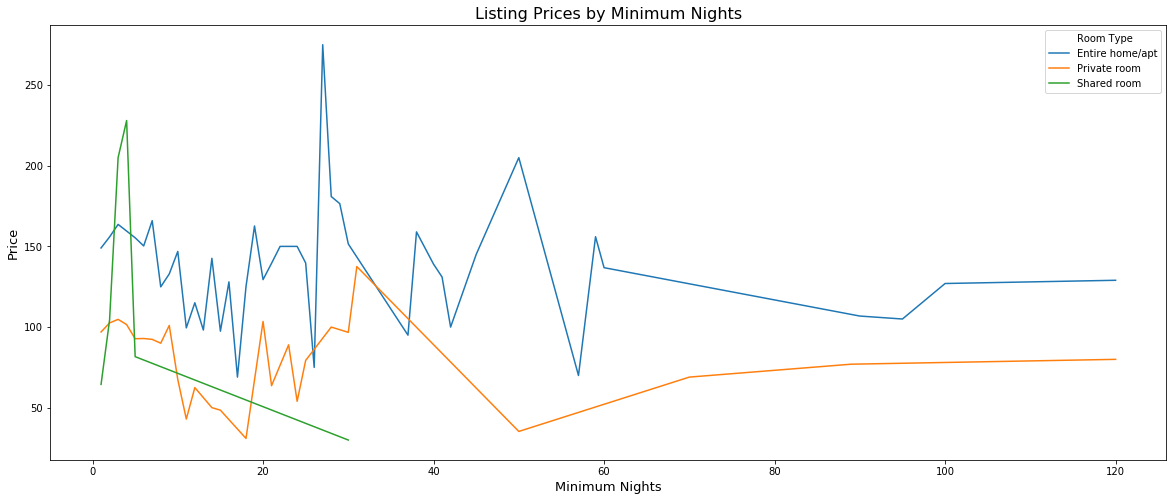

In [75]:
fig, ax = _plt.subplots(figsize=(20, 8))
x=df_listings_lt_400[['price','minimum_nights','room_type']].groupby(['minimum_nights','room_type']).mean().reset_index().rename(columns={'room_type':'Room Type'})
ax = sns.lineplot(x="minimum_nights", y="price", data=x, hue="Room Type")
ax.set_xlabel('Minimum Nights',fontsize=13)
ax.set_ylabel('Price',fontsize=13)
ax.set_title('Listing Prices by Minimum Nights', fontsize=16)
_plt.savefig('resources/price_min_night_lineplot.png')
_plt.show()

### Find cluster with highest price

In [11]:
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

cluster_dataset = pd.get_dummies(df_listings_lt_400[['room_type']], prefix="", prefix_sep="")
cluster_dataset['price'] = df_listings_lt_400['price']
cluster_dataset['latitude'] = df_listings_lt_400['latitude']
cluster_dataset['longitude'] = df_listings_lt_400['longitude']
cluster_dataset['minimum_nights'] = df_listings_lt_400['minimum_nights']
cluster_dataset_ft = StandardScaler().fit_transform(cluster_dataset)

k_means = KMeans(init="k-means++", n_clusters=6, n_init=10)
k_means.fit(cluster_dataset_ft)
labels = k_means.labels_

cluster_dataset["Labels"] = np.array(labels)
cluster_dataset_grouped = cluster_dataset.groupby('Labels').mean().sort_values('price',ascending=False)
cluster_dataset_grouped

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Entire home/apt,Private room,Shared room,price,latitude,longitude,minimum_nights
Labels,,,,,,,
0,0.993480,0.006520,0.0,262.673301,52.364542,4.887148,2.940631
3,1.000000,0.000000,0.0,133.734461,52.355125,4.919864,2.976157
4,0.822967,0.177033,0.0,132.086124,52.362591,4.887429,35.205742
5,1.000000,0.000000,0.0,130.055424,52.373325,4.867198,2.872598
1,0.000000,1.000000,0.0,99.199283,52.364804,4.892104,2.189549
2,0.000000,0.000000,1.0,93.813953,52.366988,4.893266,2.511628


In [12]:
cluster_label = np.array(cluster_dataset_grouped[cluster_dataset_grouped['price']>=250].reset_index()['Labels'])
cluster_high = cluster_dataset[cluster_dataset['Labels'].isin(cluster_label)]

cluster_label = np.array(250>cluster_dataset_grouped[cluster_dataset_grouped['price']>100].reset_index()['Labels'])
cluster_med = cluster_dataset[cluster_dataset['Labels'].isin(cluster_label)][['latitude','longitude']]

cluster_label = np.array(cluster_dataset_grouped[cluster_dataset_grouped['price']<=100].reset_index()['Labels'])
cluster_low = cluster_dataset[cluster_dataset['Labels'].isin(cluster_label)][['latitude','longitude']]


In [14]:
cluster_dataset_grouped.sort_values('Labels')

,Entire home/apt,Private room,Shared room,price,latitude,longitude,minimum_nights
Labels,,,,,,,
0,0.993480,0.006520,0.0,262.673301,52.364542,4.887148,2.940631
1,0.000000,1.000000,0.0,99.199283,52.364804,4.892104,2.189549
2,0.000000,0.000000,1.0,93.813953,52.366988,4.893266,2.511628
3,1.000000,0.000000,0.0,133.734461,52.355125,4.919864,2.976157
4,0.822967,0.177033,0.0,132.086124,52.362591,4.887429,35.205742
5,1.000000,0.000000,0.0,130.055424,52.373325,4.867198,2.872598


In [15]:
map_ams = folium.Map(location=[ams_lat, ams_long], zoom_start=14)

for lat, lng, price in zip(cluster_dataset_grouped['latitude'], cluster_dataset_grouped['longitude'], cluster_dataset_grouped['price']):
    if price>=250:
        color='red'
    elif 250>price>100:
        color='orange'
    elif price<=100:
        color='green'
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup='{},{}'.format(lat,lng),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)
map_ams

## Popularity

In [76]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [77]:

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
api_key = ''

df_category = pd.read_csv('data/categories.csv')
def get_category_type(row):     
    cat_type = list(df_category[df_category['name'].isin([row])]['type'])
    #print(cat_type['type'])
    if len(cat_type)>0:
        return cat_type[0]
    else:
        return None
    
def get_venues(latitude,longitude) :
    radius=500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        float(latitude), 
        float(longitude), 
        radius)
    
    results = requests.get(url).json()    
    
    return results

def get_coords(address):
    url = 'https://api.opencagedata.com/geocode/v1/json?q={}&key={}&language=en&pretty=1&no_annotations=1'.format(
            address,
            api_key)

    results = requests.get(url).json()    
    results = pd.json_normalize(results['results'])
    latitude = results[results['confidence']>7][['bounds.northeast.lat','bounds.southwest.lat']].mean().mean()
    longitude = results[results['confidence']>7][['bounds.northeast.lng','bounds.southwest.lng']].mean().mean()
    
    return latitude,longitude

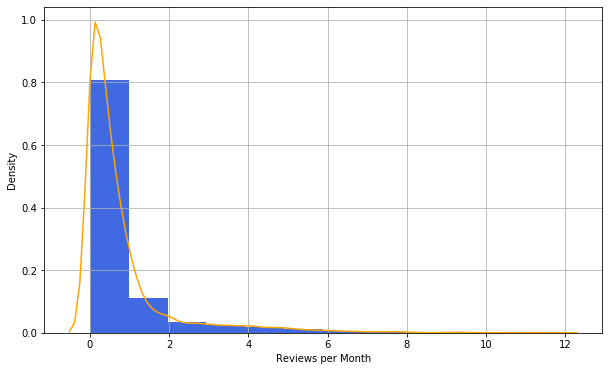

In [78]:
df_listings_lt_6_rpm = df_listings_lt_400.query('6>reviews_per_month>0')
bins = 12
fig, ax = _plt.subplots(figsize=(10, 6))
_plt.grid(b=None)
ax = sns.distplot(df_listings_lt_400['reviews_per_month'], bins=bins, kde=True, color='orange', hist_kws={"linewidth": 10,'alpha':1, 'color':'royalblue'})
ax.set(xlabel='Reviews per Month', ylabel='Density')
_plt.savefig('resources/rpm_dist.png')
_plt.show()

In [82]:
df_listings_pop = df_listings_lt_6_rpm.query('room_type != "Shared room"').sort_values(by='reviews_per_month', ascending=False).head(800)
cols = ['neighbourhood','latitude','longitude','room_type','price','minimum_nights','reviews_per_month','calculated_host_listings_count']
df_listings_pop = df_listings_pop[cols]

for cat in df_category['type'].unique() :
    df_listings_pop[cat] = 0

df_listings_pop.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
12616,Centrum-Oost,52.36251,4.88402,Private room,99,1,5.99,2,0,0,0,0,0,0,0,0,0,0
168,Centrum-West,52.37824,4.88532,Private room,85,3,5.98,1,0,0,0,0,0,0,0,0,0,0
8437,Bos en Lommer,52.38234,4.85500,Private room,70,2,5.97,2,0,0,0,0,0,0,0,0,0,0
335,De Pijp - Rivierenbuurt,52.34557,4.89620,Private room,80,1,5.97,1,0,0,0,0,0,0,0,0,0,0
12458,Centrum-Oost,52.36231,4.89976,Private room,140,2,5.97,2,0,0,0,0,0,0,0,0,0,0


In [87]:
for idx, row in df_listings_pop.iterrows(): 
    latitude = row['latitude']
    longitude = row['longitude']
    neighbourhood = row['neighbourhood']
    #print('{} : {},{}'.format(neighbourhood, latitude,longitude))
    
    results = get_venues(latitude, longitude)
    if (results['meta'].get('code')==200) & (results['response'].get('totalResults') > 0):
        venues = pd.json_normalize(results['response']['groups'][0]['items'])[['venue.categories']]# flatten JSON
        venues['name'] = venues['venue.categories'].apply(lambda x:x[0].get('name'))    
        venues['type'] = venues['name'].apply(lambda y: get_category_type(y))
        counts = venues['type'].value_counts() 
        
        for count in counts.index:
            df_listings_pop.at[idx,count] = counts[count]
            
df_listings_pop.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Centrum-Oost,52.36251,4.88402,Private room,99,1,5.99,2,9,0,0,10,3,3,0,0,3,1
1,Centrum-West,52.37824,4.88532,Private room,85,3,5.98,1,1,0,0,16,5,0,0,0,5,2
2,Bos en Lommer,52.38234,4.85500,Private room,70,2,5.97,2,1,0,0,16,1,2,0,0,5,2
3,De Pijp - Rivierenbuurt,52.34557,4.89620,Private room,80,1,5.97,1,0,0,0,24,1,1,0,0,1,1
4,Centrum-Oost,52.36231,4.89976,Private room,140,2,5.97,2,2,0,0,15,3,2,0,0,4,3


In [86]:
df_listings_pop.describe(include="all")

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,800,800.000000,800.000000,800,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.0,800.000000,800.000000,800.000000,800.000000,800.0,800.000000,800.00000
unique,22,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Centrum-West,NaN,NaN,Private room,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,191,NaN,NaN,665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,52.366430,4.891469,NaN,109.821250,2.043750,4.423150,1.822500,0.245000,0.001250,0.0,1.520000,0.392500,0.217500,0.020000,0.0,0.573750,0.26625
std,NaN,0.018217,0.036609,NaN,50.730477,0.871944,0.710509,2.078194,1.026544,0.035355,0.0,4.487736,1.346555,0.737138,0.140088,0.0,1.772989,0.88676
min,NaN,52.290220,4.771890,NaN,30.000000,1.000000,3.360000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
25%,NaN,52.358268,4.874005,NaN,75.000000,1.000000,3.830000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
50%,NaN,52.368085,4.891170,NaN,95.500000,2.000000,4.320000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
75%,NaN,52.375700,4.907122,NaN,130.000000,3.000000,4.970000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000


In [88]:
venue_cols = ['reviews_per_month', 'Arts & Entertainment', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Shop & Service', 'Travel & Transport']
df_listings_venues = df_listings_pop.copy()
df_listings_venues = df_listings_venues[venue_cols]
df_listings_venues.fillna(0, inplace=True)
df_listings_venues.head()

,reviews_per_month,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
0,5.99,9,10,3,3,3,1
1,5.98,1,16,5,0,5,2
2,5.97,1,16,1,2,5,2
3,5.97,0,24,1,1,1,1
4,5.97,2,15,3,2,4,3


#### Correlation between number/type of venues and popularity 

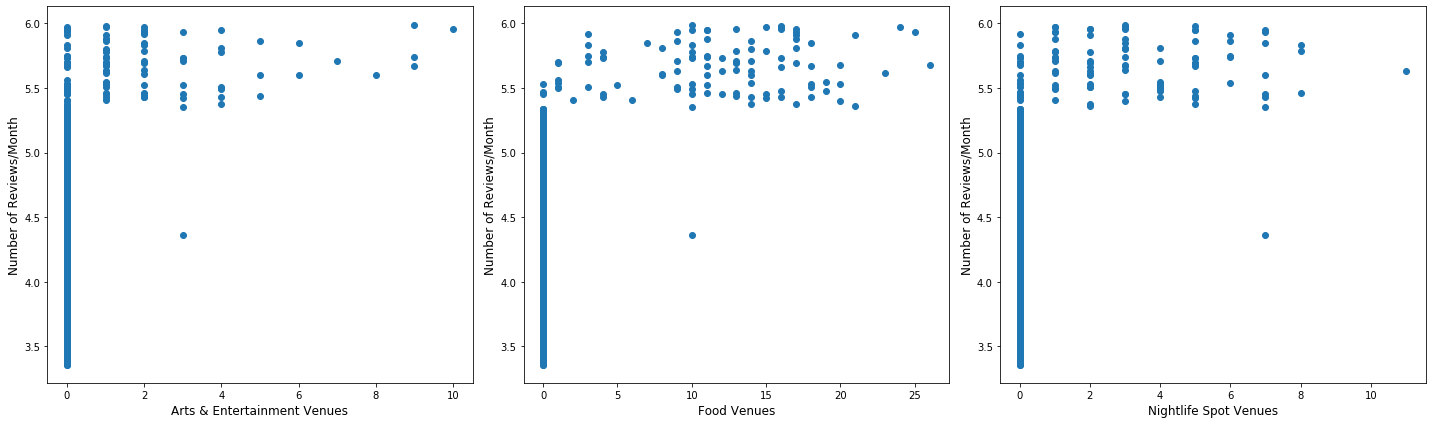

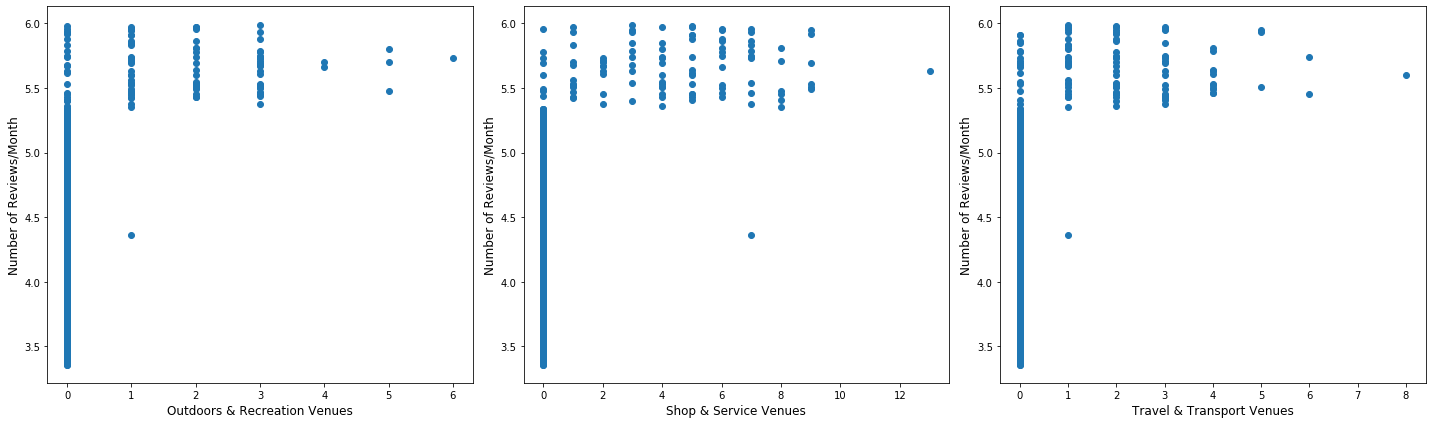

In [29]:
number_of_features = len(venue_cols)-1
fig, ax = _plt.subplots(figsize=(20, 6)) 
subplot = 100 + number_of_features/2*10 
for i in venue_cols[1:4]: 
    subplot = subplot+1
    _plt.subplot(subplot)
    _plt.scatter(x=i, y="reviews_per_month", data=df_listings_venues)
    _plt.ylabel('Number of Reviews/Month', fontsize=12)
    _plt.xlabel('{} Venues'.format(i), fontsize=12)
_plt.tight_layout()
_plt.savefig('resources/review_venues_scatter1.png')
_plt.show()

fig, ax = _plt.subplots(figsize=(20, 6)) 
subplot = 100 + number_of_features/2*10 
for i in venue_cols[4:]: 
    subplot = subplot+1
    _plt.subplot(subplot)
    _plt.scatter(x=i, y="reviews_per_month", data=df_listings_venues)
    _plt.ylabel('Number of Reviews/Month', fontsize=12)
    _plt.xlabel('{} Venues'.format(i), fontsize=12)
_plt.tight_layout()
_plt.savefig('resources/review_venues_scatter2.png')
_plt.show()

In [30]:
df_listings_venues['Popular'] = [i>=5 for i in df_listings_venues['reviews_per_month']]
df_listings_venues.reset_index(drop=True, inplace=True)
df_listings_venues

,reviews_per_month,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Popular
0,5.99,9,10,3,3,3,1,True
1,5.98,1,16,5,0,5,2,True
2,5.97,1,16,1,2,5,2,True
3,5.97,0,24,1,1,1,1,True
4,5.97,2,15,3,2,4,3,True
...,...,...,...,...,...,...,...,...
795,3.37,0,0,0,0,0,0,False
796,3.37,0,0,0,0,0,0,False
797,3.37,0,0,0,0,0,0,False
798,3.36,0,0,0,0,0,0,False


In [31]:
features = df_listings_venues[venue_cols[1:]]
features.head()

,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
0,9,10,3,3,3,1
1,1,16,5,0,5,2
2,1,16,1,2,5,2
3,0,24,1,1,1,1
4,2,15,3,2,4,3


In [34]:
target = np.array(df_listings_venues['Popular'])
target[:5]

array([ True,  True,  True,  True,  True])

In [35]:
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=4)
print ('Train set:', feature_train.shape,  target_train.shape)
print ('Test set:', feature_test.shape,  target_test.shape)

Train set: (640, 6) (640,)
Test set: (160, 6) (160,)


#### K Nearest Neighbor(KNN)

In [36]:
Ks = 100
mean_acc_knn = np.zeros((Ks-1))

for n in range(2,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(feature_train,target_train)
    yhat=neigh.predict(feature_test)
    mean_acc_knn[n-1] = metrics.accuracy_score(target_test, yhat)  
    
print( "The best accuracy was with", mean_acc_knn.max(), "with k=", mean_acc_knn.argmax()+1) 
best_k = mean_acc_knn.argmax()+1

The best accuracy was with 0.85625 with k= 2


In [37]:
neigh = KNeighborsClassifier(n_neighbors = best_k).fit(feature_train,target_train)
yhat_knn = neigh.predict(feature_test)
jac_knn = jaccard_similarity_score(target_test,yhat_knn).round(4)
print('Jaccard Index = {}'.format(jac_knn))
f1_knn = f1_score(target_test,yhat_knn, average='weighted', labels=np.unique(yhat_knn)).round(4)
print('F1-score = {}'.format(f1_knn))

Jaccard Index = 0.8562
F1-score = 0.8335


#### Logistic Regression

In [38]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(feature_train,target_train)
yhat_lr = LR.predict(feature_test)
yhat_prob = LR.predict_proba(feature_test)
jac_lr = jaccard_similarity_score(target_test,yhat_lr).round(4)
print('Jaccard Index = {}'.format(jac_lr))
f1_lr = f1_score(target_test,yhat_lr, average='weighted', labels=np.unique(yhat_lr)).round(4)
print('F1-score = {}'.format(f1_lr))

Jaccard Index = 0.8438
F1-score = 0.8156


## Availability

In [43]:
from matplotlib.dates import date2num
from datetime import datetime

In [44]:
df_calendar = pd.read_csv('data/calendar.csv')
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,52490,2020-03-14,f,$75.00,$75.00,2.0,80.0
1,2818,2020-03-14,f,$69.00,$69.00,3.0,1125.0
2,2818,2020-03-15,t,$69.00,$69.00,3.0,1125.0
3,2818,2020-03-16,t,$59.00,$59.00,3.0,1125.0
4,2818,2020-03-17,t,$59.00,$59.00,3.0,1125.0


In [45]:
df_calendar_pivot = df_calendar.pivot(index='listing_id', columns='date', values='available').reset_index()
df_calendar_pivot.drop(columns='2020-03-13',inplace=True)
df_calendar_pivot.rename(columns={'listing_id':'id'},inplace=True)
df_calendar_pivot.index.name=''
df_calendar_pivot.head()

date,id,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,...,2021-03-04,2021-03-05,2021-03-06,2021-03-07,2021-03-08,2021-03-09,2021-03-10,2021-03-11,2021-03-12,2021-03-13
,,,,,,,,,,,,,,,,,,,,,
0,2818,f,t,t,t,t,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
1,20168,f,t,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
2,25428,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
3,27886,f,f,f,f,t,t,f,f,f,...,t,t,t,t,t,t,t,t,t,t
4,28871,f,t,t,t,t,t,t,t,t,...,t,t,t,t,t,t,t,t,t,t


#### Create dataframe with occupancy % timeseries

In [92]:
df_calendar_desc = df_calendar_pivot.describe(include="all")
df_calendar_desc

date,id,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,...,2021-03-04,2021-03-05,2021-03-06,2021-03-07,2021-03-08,2021-03-09,2021-03-10,2021-03-11,2021-03-12,2021-03-13
count,1.963500e+04,19635,19635,19635,19635,19635,19635,19635,19635,19635,...,19635,19635,19635,19635,19635,19635,19635,19635,19635,19042
unique,NaN,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,NaN,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
freq,NaN,18113,16833,16338,16189,16189,16399,16713,16713,16197,...,16772,16771,16769,16776,16723,16724,16726,16726,16726,16136
mean,1.969944e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.198990e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.818000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,9.831484e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.873380e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.897051e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
occupancy_pc = [[],[]]
for column in df_calendar_desc.columns[1:]:
    occupancy_pc[0].append(datetime.strptime(column, "%Y-%m-%d"))
    count=df_calendar_desc[column].loc['count']
    freq=df_calendar_desc[column].loc['freq']
    if df_calendar_desc[column].loc['top'] == 'f':
        occupancy_pc[1].append(float((count-freq)*100/count.round(2)))
    else:
        occupancy_pc[1].append(float(freq*100/count.round(2)))

occupancy_pc = pd.DataFrame(occupancy_pc).T
occupancy_pc.rename(columns={0:'date',1:'occupancy'},inplace=True)

In [106]:
occupancy_pc.head()

,date,occupancy
0,2020-03-14,7.75146
1,2020-03-15,14.2704
2,2020-03-16,16.7914
3,2020-03-17,17.5503
4,2020-03-18,17.5503


In [97]:
occupancy_monthly_daily = occupancy_pc.copy()
#occupancy_monthly_daily['month'] = occupancy_monthly_daily['date'].apply(lambda x: x.strftime("%b"))
occupancy_monthly_daily['day'] = occupancy_monthly_daily['date'].apply(lambda x: x.strftime("%a"))
occupancy_monthly_daily.head()

,date,occupancy,day
0,2020-03-14,7.75146,Sat
1,2020-03-15,14.2704,Sun
2,2020-03-16,16.7914,Mon
3,2020-03-17,17.5503,Tue
4,2020-03-18,17.5503,Wed


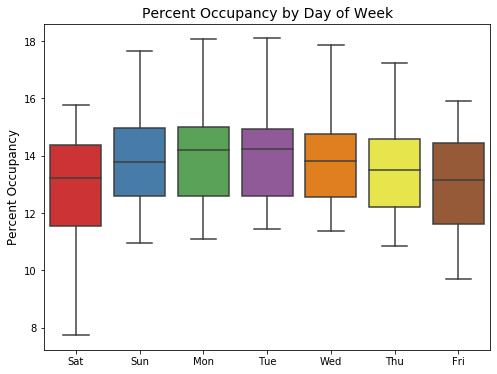

In [98]:
fig, ax = _plt.subplots(figsize=(8, 6))
ax = sns.boxplot(x='day', y='occupancy', data=occupancy_monthly_daily, palette="Set1")
ax.set_xlabel('',fontsize=12)
ax.set_ylabel('Percent Occupancy',fontsize=12)
ax.set_title('Percent Occupancy by Day of Week', fontsize=14)
_plt.savefig('resources/daily_occupancy.png')
_plt.show()

In [120]:
resample = occupancy_pc.copy()
resample.set_index('date', inplace=True)
resample.index.name = ''
resample = resample.astype({'occupancy': 'float'})
occupancy_pc_monthly_mean = resample.resample('M').mean()
occupancy_pc_monthly_mean.head()

,occupancy
,
2020-03-31,16.307614
2020-04-30,13.386809
2020-05-31,14.045032
2020-06-30,13.459299
2020-07-31,14.511118


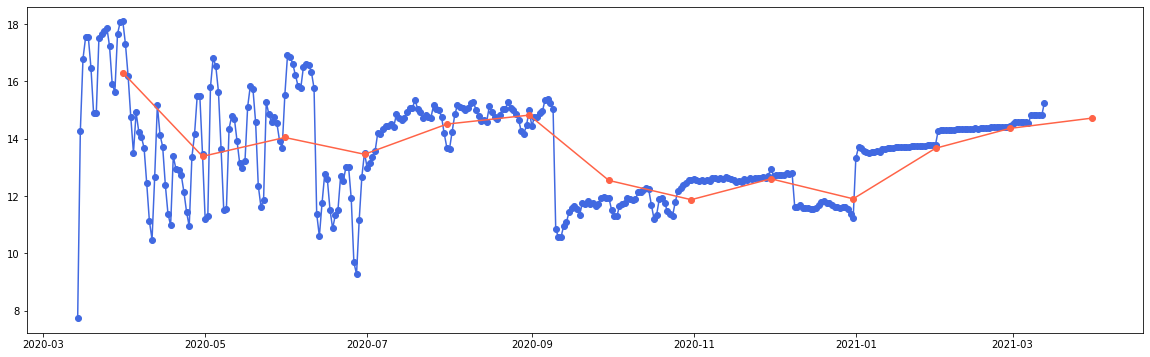

In [123]:
fig, ax = _plt.subplots(figsize=(20, 6))
_plt.plot_date(occupancy_pc['date'],occupancy_pc['occupancy'], linestyle ='solid', color='royalblue')
_plt.plot_date(occupancy_pc_monthly_mean.index,occupancy_pc_monthly_mean['occupancy'], linestyle ='solid', color='tomato')
_plt.savefig('resources/downsampling_monthly_means.png')